# L3d: Recurrent Neural Networks

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from patsy import dmatrices
from collections import OrderedDict
import itertools

from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_percentage_error
from sklearn.preprocessing import scale

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, RNN, GRU, Attention, Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers, Input
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


In [4]:
def reset_weights(model):
	"""This function re-initializes model weights at each compile"""
	for layer in model.layers: 
		if isinstance(layer, tf.keras.Model):
			reset_weights(layer)
			continue
	for k, initializer in layer.__dict__.items():
		if "initializer" not in k:
			continue
		# find the corresponding variable
		var = getattr(layer, k.replace("_initializer", ""))
		var.assign(initializer(var.shape, var.dtype))

## In this example, we will use an LSTM to predict monthly average temperatures in Boston, using the 12-month lagged dataset.

In [8]:
#Read the data set into a pandas DataFrame
df = pd.read_csv('data/boston_monthly_avg_temps_1978_2019.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
#resample at a month level
#df_resampled = df.resample('M').mean()

/tmp/ipykernel_449563/3110023198.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('data/boston_monthly_avg_temps_1978_2019.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])


In [5]:
df.head()

,TAVG,TAVG_LAG_1,TAVG_LAG_2,TAVG_LAG_3,TAVG_LAG_4,TAVG_LAG_5,TAVG_LAG_6,TAVG_LAG_7,TAVG_LAG_8,TAVG_LAG_9,TAVG_LAG_10,TAVG_LAG_11,TAVG_LAG_12
DATE,,,,,,,,,,,,,
1980-01-31,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333,42.451613,23.071429,32.451613
1980-02-29,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333,42.451613,23.071429
1980-03-31,36.822581,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333,42.451613
1980-04-30,48.716667,36.822581,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333
1980-05-31,59.387097,48.716667,36.822581,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032


In [22]:
split_index = round(len(df)*0.8)
split_date = df.index[split_index]
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [23]:
X_train = df_train.iloc[:,1:13]
y_train = df_train.iloc[:,0]
X_test = df_test.iloc[:,1:13] 
y_test = df_test.iloc[:,0]

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)


(383, 12)
(383,)
(95, 12)


In [25]:
X_train.head()

,TAVG_LAG_1,TAVG_LAG_2,TAVG_LAG_3,TAVG_LAG_4,TAVG_LAG_5,TAVG_LAG_6,TAVG_LAG_7,TAVG_LAG_8,TAVG_LAG_9,TAVG_LAG_10,TAVG_LAG_11,TAVG_LAG_12
DATE,,,,,,,,,,,,
1980-01-31,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333,42.451613,23.071429,32.451613
1980-02-29,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333,42.451613,23.071429
1980-03-31,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333,42.451613
1980-04-30,36.822581,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032,48.683333
1980-05-31,48.716667,36.822581,27.810345,29.403226,36.629032,48.566667,52.629032,64.883333,71.661290,74.483871,68.166667,61.129032


In [26]:
np.asarray(X_train)

array([[36.62903226, 48.56666667, 52.62903226, ..., 42.4516129 ,
        23.07142857, 32.4516129 ],
       [29.40322581, 36.62903226, 48.56666667, ..., 48.68333333,
        42.4516129 , 23.07142857],
       [27.81034483, 29.40322581, 36.62903226, ..., 61.12903226,
        48.68333333, 42.4516129 ],
       ...,
       [73.90322581, 77.30645161, 67.08333333, ..., 44.78333333,
        55.59677419, 68.65      ],
       [67.28333333, 73.90322581, 77.30645161, ..., 32.67741935,
        44.78333333, 55.59677419],
       [57.53225806, 67.28333333, 73.90322581, ..., 27.56451613,
        32.67741935, 44.78333333]])

Now we reshape in the inputs and targets as [samples, timesteps, features]. Think of "timesteps" as the number of lag variables.

In [27]:
X_train = np.reshape(np.asarray(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(np.asarray(X_test), (X_test.shape[0], X_test.shape[1], 1))
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [28]:
print(X_train.shape)

(383, 12, 1)


### LSTM implementation

In [14]:
#reset_weights(model)

In [58]:
K.clear_session()
model = Sequential()
model.add(LSTM(units = 24, input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(LSTM(units = 12, input_shape = (24,12)))
model.add(Dense(8, activation = "linear")) # transform hidden unit activations to single output (monthly average temperature)
model.add(Dense(1, activation = "linear")) # transform hidden unit activations to single output (monthly average temperature)
model.compile(loss = 'mse', optimizer = 'adam')


In [46]:
# input_seq = Input(shape=(12, 1))

# # LSTM Encoder (return sequences for attention)
# lstm_out = LSTM(8, return_sequences=True)(input_seq)

# # Attention Layer
# # In Keras, the Attention layer calculates scores and applies softmax automatically
# # It expects a query, key, and value. Here, lstm_out serves as both key and value,
# # and we can use the last hidden state as the query (or a separate learnable vector)
# query = lstm_out[:, -1, :] # Example: using the last hidden state as query
# context_vector = Attention()([query, lstm_out, lstm_out]) # Query, Key, Value

# # Concatenate context vector with last LSTM output (or other relevant output)
# combined_output = Concatenate()([lstm_out[:, -1, :], context_vector])

# # Output Layer
# output = Dense(1, activation='linear')(combined_output)

# # Create model
# model = Model(inputs=input_seq, outputs=output)

# model.compile(loss = 'mse', optimizer = 'adam')


In [43]:
#model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0);

In [59]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,705 (10.57 KB)

 Trainable params: 2,705 (10.57 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
early_stopping = EarlyStopping(monitor='loss', patience=7, min_delta = 0.001, restore_best_weights=True, 
                                mode = "min")

In [61]:
hist = model.fit(X_train, y_train, batch_size = 16,
                 validation_data = (X_test, y_test), 
                 verbose = 0, epochs = 600)

In [62]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Train MSE')
  plt.plot(history.history['val_loss'], label='Test MSE')
  #plt.ylim([0, 40]) # adjust to zoom in/out accordingly
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

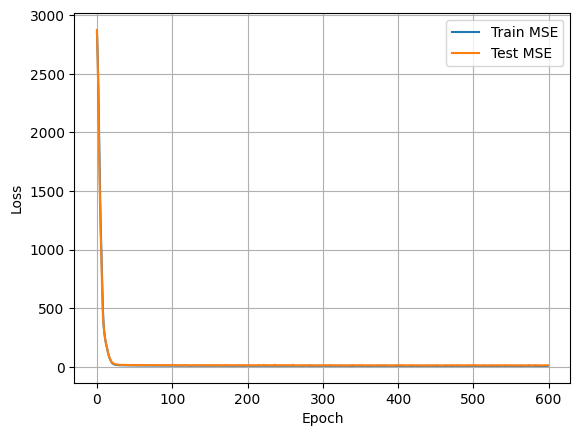

In [67]:
plot_loss(hist)

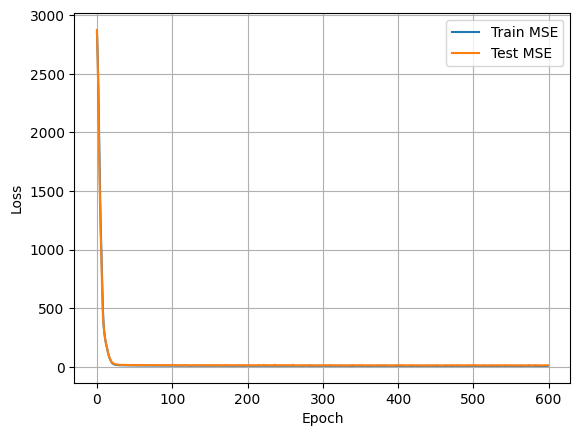

In [68]:
plot_loss(hist) # with ylimit at 40

We see that the optimism begins to increase significantly after 600 epochs (the early stopping monitor should automatically revert the weights of the network to the optimal point)

In [69]:
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [70]:
y_test_pred = pd.DataFrame(df_test.iloc[:,0])
y_test_pred.columns  = ['Observed']
y_test_pred['Predicted'] = y_pred

In [66]:
?mean_absolute_percentage_error

Signature:
mean_absolute_percentage_error(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    multioutput='uniform_average',
)
Docstring:
Mean absolute percentage error (MAPE) regression loss.

Note that we are not using the common "percentage" definition: the percentage
in the range [0, 100] is converted to a relative value in the range [0, 1]
by dividing by 100. Thus, an error of 200% corresponds to a relative error of 2.

Read more in the :ref:`User Guide <mean_absolute_percentage_error>`.

.. versionadded:: 0.24

Parameters
----------
y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Ground truth (correct) target values.

y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
    Estimated target values.

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

multioutput : {'raw_values', 'uniform_average'} or array-like
    Defines aggregating of multiple output values.
    Array-like value defines weights used

In [74]:
mape = mean_absolute_percentage_error(y_test_pred['Observed'], y_test_pred['Predicted'])
print(mape)

0.06503239918149223


<Axes: xlabel='DATE'>

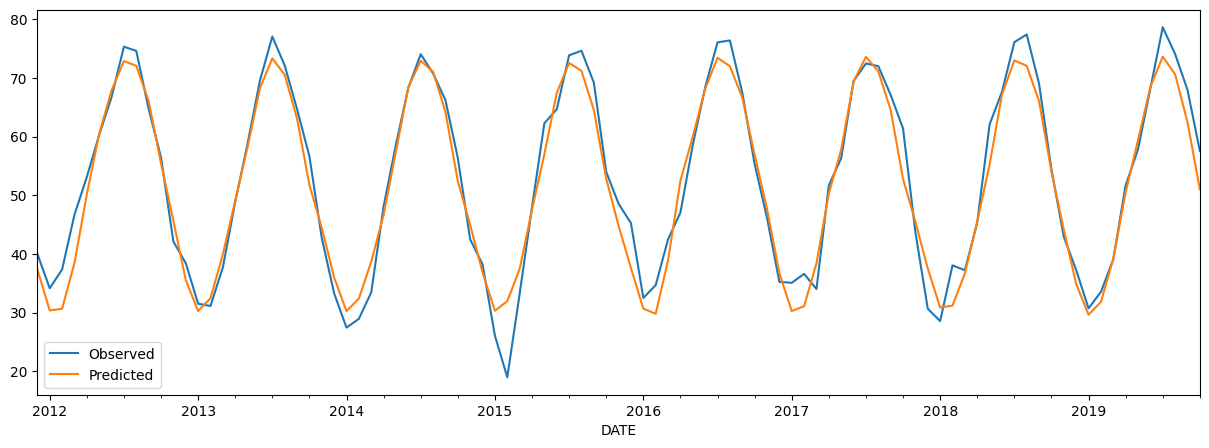

In [75]:
y_test_pred.plot(figsize=(15,5))

Text(0, 0.5, 'Count')

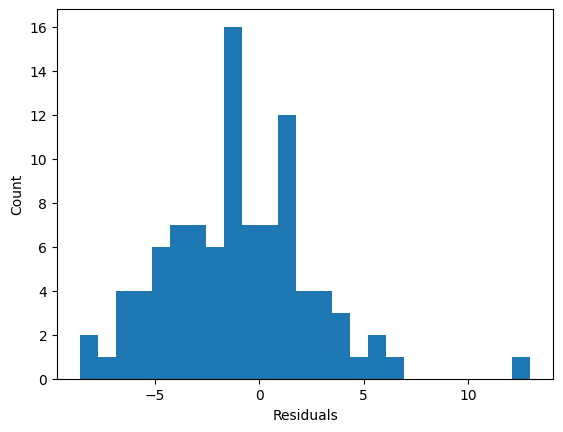

In [76]:
error = y_pred.flatten() - y_test
plt.hist(error, bins=25)
plt.xlabel('Residuals')
plt.ylabel('Count')

In [77]:
np.mean(error)

np.float64(-1.020217006270859)